In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
import random # we don't fix seed here so can use to re sample test patients

Global seed set to 0


In [2]:
# if want to change global seed to sth else
seed = 0
from scvi._settings import settings
settings.seed = seed

Global seed set to 0


In [131]:
sc.set_figure_params(dpi=100, frameon=False)

# Read data

In [3]:
# adt.h5ad is full dataset, change to adt_test.h5ad for a smaller subset
adt = sc.read('data/haniffa-2021/adt.h5ad')
adt

AnnData object with n_obs × n_vars = 624325 × 192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch'
    var: 'feature_types'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [501]:
# rna.h5ad is full dataset, change to rna_test.h5ad for a smaller subset
rna = sc.read('data/haniffa-2021/rna.h5ad')
rna

AnnData object with n_obs × n_vars = 624325 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

subset to 2000 hvgs for computational complexity 

In [5]:
rna = rna[:, rna.var.index[:2000]]

In [6]:
idx = adt.obs['patient_id'].sort_values().index # need to sort by patient for the data loader

In [7]:
adt = adt[idx].copy()
rna = rna[idx].copy()

# MIL

In [8]:
# arange modality adatas into one adata
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],
    groups = [[0], [0]],
    layers = [['count'], [None]],
)
adata

AnnData object with n_obs × n_vars = 624325 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'group'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'count'

In [9]:
len(adata.obs['patient_id'].cat.categories)

113

In [10]:
# if want to leave out patients as test uncomment the next two cells
number_of_test_patients = 20
patients = list(adata.obs['patient_id'].cat.categories)
test_patient_ids = random.sample(patients, number_of_test_patients)
adata[adata.obs.patient_id.isin(test_patient_ids)].obs[['Status_on_day_collection_summary', 'patient_id']].drop_duplicates().groupby('Status_on_day_collection_summary').count() # check class distribution for test set

,patient_id
Status_on_day_collection_summary,
Asymptomatic,2
Critical,4
Healthy,7
Mild,3
Moderate,3
Severe,1


In [11]:
# subset
adata_test = adata[adata.obs.patient_id.isin(test_patient_ids)].copy()
adata = adata[~adata.obs.patient_id.isin(test_patient_ids)].copy()

In [12]:
mtg.model.MultiVAE_MIL.setup_anndata(
            adata, 
            class_label="Status_on_day_collection_summary",
            rna_indices_end=2000,
            categorical_covariate_keys=['Sex', 'Age_interval', 'patient_id'],
            continuous_covariate_keys=None,)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 524368 cells, 2192 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 4 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [13]:
mil = mtg.model.MultiVAE_MIL(
            adata, 
            modality_lengths=[2000, 192],
            losses=['nb', 'mse'],
            loss_coefs={'kl': 1e-5, 'integ': 0},
            class_label='Status_on_day_collection_summary',
            patient_label='patient_id',
            scoring='gated_attn', # or 'attn'
            class_layers=2,
            add_patient_to_classifier=False, # whether to use patient embeddings for classification
            hierarchical_attn=True, # whether to have hierarchical attention or just cell attention,

        )

In [14]:
mil.train(max_epochs=100, 
    batch_size=256)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   1%|          | 1/100 [00:27<44:24, 26.91s/it, loss=337, v_num=1]

Metric elbo_validation improved. New best score: 333.434


Epoch 2/100:   2%|▏         | 2/100 [00:57<46:57, 28.75s/it, loss=306, v_num=1]

Metric elbo_validation improved by 48.755 >= min_delta = 0.0. New best score: 284.678


Epoch 3/100:   3%|▎         | 3/100 [01:27<47:23, 29.31s/it, loss=281, v_num=1]

Metric elbo_validation improved by 15.989 >= min_delta = 0.0. New best score: 268.689


Epoch 4/100:   4%|▍         | 4/100 [01:57<47:18, 29.57s/it, loss=267, v_num=1]

Metric elbo_validation improved by 10.488 >= min_delta = 0.0. New best score: 258.200


Epoch 5/100:   5%|▌         | 5/100 [02:27<47:02, 29.71s/it, loss=253, v_num=1]

Metric elbo_validation improved by 7.639 >= min_delta = 0.0. New best score: 250.561


Epoch 6/100:   6%|▌         | 6/100 [02:57<46:51, 29.91s/it, loss=247, v_num=1]

Metric elbo_validation improved by 6.413 >= min_delta = 0.0. New best score: 244.148


Epoch 7/100:   7%|▋         | 7/100 [03:27<46:21, 29.91s/it, loss=256, v_num=1]

Metric elbo_validation improved by 3.502 >= min_delta = 0.0. New best score: 240.647


Epoch 8/100:   8%|▊         | 8/100 [03:57<45:56, 29.96s/it, loss=256, v_num=1]

Metric elbo_validation improved by 3.011 >= min_delta = 0.0. New best score: 237.636


Epoch 9/100:   9%|▉         | 9/100 [04:27<45:25, 29.96s/it, loss=250, v_num=1]

Metric elbo_validation improved by 1.862 >= min_delta = 0.0. New best score: 235.775


Epoch 10/100:  10%|█         | 10/100 [04:57<44:56, 29.96s/it, loss=262, v_num=1]

Metric elbo_validation improved by 1.412 >= min_delta = 0.0. New best score: 234.362


Epoch 11/100:  11%|█         | 11/100 [05:27<44:33, 30.04s/it, loss=237, v_num=1]

Metric elbo_validation improved by 1.635 >= min_delta = 0.0. New best score: 232.727


Epoch 12/100:  12%|█▏        | 12/100 [05:58<44:35, 30.40s/it, loss=240, v_num=1]

Metric elbo_validation improved by 1.179 >= min_delta = 0.0. New best score: 231.548


Epoch 13/100:  13%|█▎        | 13/100 [06:30<44:39, 30.80s/it, loss=241, v_num=1]

Metric elbo_validation improved by 0.945 >= min_delta = 0.0. New best score: 230.603


Epoch 14/100:  14%|█▍        | 14/100 [07:02<44:37, 31.13s/it, loss=240, v_num=1]

Metric elbo_validation improved by 1.155 >= min_delta = 0.0. New best score: 229.448


Epoch 15/100:  15%|█▌        | 15/100 [07:32<43:43, 30.87s/it, loss=246, v_num=1]

Metric elbo_validation improved by 0.564 >= min_delta = 0.0. New best score: 228.884


Epoch 16/100:  16%|█▌        | 16/100 [08:04<43:25, 31.02s/it, loss=240, v_num=1]

Metric elbo_validation improved by 0.728 >= min_delta = 0.0. New best score: 228.156


Epoch 17/100:  17%|█▋        | 17/100 [08:35<43:01, 31.11s/it, loss=234, v_num=1]

Metric elbo_validation improved by 0.739 >= min_delta = 0.0. New best score: 227.418


Epoch 18/100:  18%|█▊        | 18/100 [09:06<42:36, 31.18s/it, loss=241, v_num=1]

Metric elbo_validation improved by 0.728 >= min_delta = 0.0. New best score: 226.690


Epoch 19/100:  19%|█▉        | 19/100 [09:38<42:12, 31.26s/it, loss=235, v_num=1]

Metric elbo_validation improved by 0.584 >= min_delta = 0.0. New best score: 226.106


Epoch 20/100:  20%|██        | 20/100 [10:09<41:47, 31.34s/it, loss=232, v_num=1]

Metric elbo_validation improved by 0.480 >= min_delta = 0.0. New best score: 225.625


Epoch 21/100:  21%|██        | 21/100 [10:41<41:16, 31.34s/it, loss=229, v_num=1]

Metric elbo_validation improved by 0.455 >= min_delta = 0.0. New best score: 225.170


Epoch 22/100:  22%|██▏       | 22/100 [11:12<40:47, 31.37s/it, loss=225, v_num=1]

Metric elbo_validation improved by 0.685 >= min_delta = 0.0. New best score: 224.485


Epoch 23/100:  23%|██▎       | 23/100 [11:43<40:17, 31.39s/it, loss=231, v_num=1]

Metric elbo_validation improved by 0.290 >= min_delta = 0.0. New best score: 224.195


Epoch 24/100:  24%|██▍       | 24/100 [12:15<39:47, 31.41s/it, loss=235, v_num=1]

Metric elbo_validation improved by 0.425 >= min_delta = 0.0. New best score: 223.770


Epoch 25/100:  25%|██▌       | 25/100 [12:46<39:16, 31.42s/it, loss=233, v_num=1]

Metric elbo_validation improved by 0.365 >= min_delta = 0.0. New best score: 223.405


Epoch 26/100:  26%|██▌       | 26/100 [13:17<38:32, 31.25s/it, loss=237, v_num=1]

Metric elbo_validation improved by 0.264 >= min_delta = 0.0. New best score: 223.141


Epoch 27/100:  27%|██▋       | 27/100 [13:46<37:09, 30.54s/it, loss=228, v_num=1]

Metric elbo_validation improved by 0.559 >= min_delta = 0.0. New best score: 222.582


Epoch 28/100:  28%|██▊       | 28/100 [14:17<36:46, 30.64s/it, loss=229, v_num=1]

Metric elbo_validation improved by 0.232 >= min_delta = 0.0. New best score: 222.349


Epoch 29/100:  29%|██▉       | 29/100 [14:48<36:20, 30.71s/it, loss=226, v_num=1]

Metric elbo_validation improved by 0.621 >= min_delta = 0.0. New best score: 221.728


Epoch 30/100:  30%|███       | 30/100 [15:19<35:52, 30.76s/it, loss=229, v_num=1]

Metric elbo_validation improved by 0.262 >= min_delta = 0.0. New best score: 221.466


Epoch 31/100:  31%|███       | 31/100 [15:50<35:25, 30.80s/it, loss=228, v_num=1]

Metric elbo_validation improved by 0.121 >= min_delta = 0.0. New best score: 221.345


Epoch 32/100:  32%|███▏      | 32/100 [16:20<34:55, 30.81s/it, loss=231, v_num=1]

Metric elbo_validation improved by 0.105 >= min_delta = 0.0. New best score: 221.240


Epoch 33/100:  33%|███▎      | 33/100 [16:52<34:39, 31.04s/it, loss=230, v_num=1]

Metric elbo_validation improved by 0.513 >= min_delta = 0.0. New best score: 220.727


Epoch 34/100:  34%|███▍      | 34/100 [17:22<33:57, 30.87s/it, loss=239, v_num=1]

Metric elbo_validation improved by 0.156 >= min_delta = 0.0. New best score: 220.571


Epoch 35/100:  35%|███▌      | 35/100 [17:54<33:32, 30.96s/it, loss=213, v_num=1]

Metric elbo_validation improved by 0.079 >= min_delta = 0.0. New best score: 220.492


Epoch 36/100:  36%|███▌      | 36/100 [18:25<33:06, 31.03s/it, loss=227, v_num=1]

Metric elbo_validation improved by 0.033 >= min_delta = 0.0. New best score: 220.459


Epoch 37/100:  37%|███▋      | 37/100 [18:56<32:38, 31.08s/it, loss=228, v_num=1]

Metric elbo_validation improved by 0.428 >= min_delta = 0.0. New best score: 220.031


Epoch 39/100:  39%|███▉      | 39/100 [19:58<31:37, 31.11s/it, loss=229, v_num=1]

Metric elbo_validation improved by 0.252 >= min_delta = 0.0. New best score: 219.779


Epoch 40/100:  40%|████      | 40/100 [20:29<31:08, 31.13s/it, loss=232, v_num=1]

Metric elbo_validation improved by 0.230 >= min_delta = 0.0. New best score: 219.549


Epoch 42/100:  42%|████▏     | 42/100 [21:33<30:22, 31.42s/it, loss=241, v_num=1]

Metric elbo_validation improved by 0.265 >= min_delta = 0.0. New best score: 219.284


Epoch 43/100:  43%|████▎     | 43/100 [22:05<29:55, 31.51s/it, loss=224, v_num=1]

Metric elbo_validation improved by 0.041 >= min_delta = 0.0. New best score: 219.243


Epoch 45/100:  45%|████▌     | 45/100 [23:07<28:39, 31.26s/it, loss=232, v_num=1]

Metric elbo_validation improved by 0.087 >= min_delta = 0.0. New best score: 219.156


Epoch 46/100:  46%|████▌     | 46/100 [23:38<28:03, 31.18s/it, loss=229, v_num=1]

Metric elbo_validation improved by 0.119 >= min_delta = 0.0. New best score: 219.037


Epoch 47/100:  47%|████▋     | 47/100 [24:08<27:28, 31.11s/it, loss=237, v_num=1]

Metric elbo_validation improved by 0.235 >= min_delta = 0.0. New best score: 218.802


Epoch 48/100:  48%|████▊     | 48/100 [24:39<26:51, 31.00s/it, loss=228, v_num=1]

Metric elbo_validation improved by 0.261 >= min_delta = 0.0. New best score: 218.541


Epoch 50/100:  50%|█████     | 50/100 [25:40<25:32, 30.64s/it, loss=222, v_num=1]

Metric elbo_validation improved by 0.119 >= min_delta = 0.0. New best score: 218.423


Epoch 53/100:  53%|█████▎    | 53/100 [27:13<24:15, 30.97s/it, loss=233, v_num=1]

Metric elbo_validation improved by 0.296 >= min_delta = 0.0. New best score: 218.127


Epoch 57/100:  57%|█████▋    | 57/100 [29:17<22:11, 30.97s/it, loss=223, v_num=1]

Metric elbo_validation improved by 0.302 >= min_delta = 0.0. New best score: 217.825


Epoch 63/100:  63%|██████▎   | 63/100 [32:23<19:07, 31.01s/it, loss=218, v_num=1]

Metric elbo_validation improved by 0.134 >= min_delta = 0.0. New best score: 217.690


Epoch 64/100:  64%|██████▍   | 64/100 [32:54<18:36, 31.02s/it, loss=223, v_num=1]

Metric elbo_validation improved by 0.017 >= min_delta = 0.0. New best score: 217.673


Epoch 66/100:  66%|██████▌   | 66/100 [33:57<17:41, 31.21s/it, loss=221, v_num=1]

Metric elbo_validation improved by 0.155 >= min_delta = 0.0. New best score: 217.518


Epoch 67/100:  67%|██████▋   | 67/100 [34:28<17:14, 31.35s/it, loss=222, v_num=1]

Metric elbo_validation improved by 0.125 >= min_delta = 0.0. New best score: 217.394


Epoch 72/100:  72%|███████▏  | 72/100 [37:03<14:21, 30.76s/it, loss=230, v_num=1]

Metric elbo_validation improved by 0.328 >= min_delta = 0.0. New best score: 217.066


Epoch 73/100:  73%|███████▎  | 73/100 [37:34<13:48, 30.68s/it, loss=220, v_num=1]

Metric elbo_validation improved by 0.208 >= min_delta = 0.0. New best score: 216.858


Epoch 82/100:  82%|████████▏ | 82/100 [42:13<09:08, 30.47s/it, loss=231, v_num=1]

Metric elbo_validation improved by 0.064 >= min_delta = 0.0. New best score: 216.794


Epoch 83/100:  83%|████████▎ | 83/100 [42:43<08:33, 30.20s/it, loss=227, v_num=1]

Metric elbo_validation improved by 0.053 >= min_delta = 0.0. New best score: 216.741


Epoch 85/100:  85%|████████▌ | 85/100 [43:42<07:28, 29.87s/it, loss=213, v_num=1]

Metric elbo_validation improved by 0.023 >= min_delta = 0.0. New best score: 216.718


Epoch 87/100:  87%|████████▋ | 87/100 [44:41<06:25, 29.66s/it, loss=222, v_num=1]

Metric elbo_validation improved by 0.001 >= min_delta = 0.0. New best score: 216.716


Epoch 88/100:  88%|████████▊ | 88/100 [45:10<05:55, 29.61s/it, loss=227, v_num=1]

Metric elbo_validation improved by 0.009 >= min_delta = 0.0. New best score: 216.708


Epoch 90/100:  90%|█████████ | 90/100 [46:10<04:55, 29.56s/it, loss=232, v_num=1]

Metric elbo_validation improved by 0.040 >= min_delta = 0.0. New best score: 216.668


Epoch 92/100:  92%|█████████▏| 92/100 [47:09<03:56, 29.51s/it, loss=222, v_num=1]

Metric elbo_validation improved by 0.153 >= min_delta = 0.0. New best score: 216.515


Epoch 96/100:  96%|█████████▌| 96/100 [49:09<02:01, 30.28s/it, loss=217, v_num=1]

Metric elbo_validation improved by 0.061 >= min_delta = 0.0. New best score: 216.454


Epoch 97/100:  97%|█████████▋| 97/100 [49:41<01:32, 30.76s/it, loss=235, v_num=1]

Metric elbo_validation improved by 0.055 >= min_delta = 0.0. New best score: 216.399


Epoch 99/100:  99%|█████████▉| 99/100 [50:43<00:30, 30.87s/it, loss=224, v_num=1]

Metric elbo_validation improved by 0.091 >= min_delta = 0.0. New best score: 216.308


Epoch 100/100: 100%|██████████| 100/100 [51:15<00:00, 30.76s/it, loss=231, v_num=1]


In [67]:
# save the model

In [66]:
mil.save("ref_hanifa")

In [15]:
mil_out = mil.get_latent_representation(batch_size=256)
latent, cell_attn, cov_attn, _ = mil_out

/home/mo/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [16]:
adata.obsm['latent'] = latent
adata.obs['cell_attn'] = cell_attn

In [17]:
# subsmaple the data for visualizaion 

In [18]:
ss_adata= sc.pp.subsample(adata, 0.2, copy=True)

In [21]:
ss_adata

AnnData object with n_obs × n_vars = 104873 × 2192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'group', 'size_factors', '_scvi_batch', '_scvi_labels', 'cell_attn'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent'
    layers: 'count'

In [95]:
ss_adata.obs.initial_clustering.value_counts()

CD4             500
CD14            388
CD8             343
NK_16hi         318
B_cell          223
CD16             81
Platelets        56
Treg             38
Lymph_prolif     35
NK_56hi          35
Plasmablast      32
gdT              31
pDC              22
MAIT             22
DCs              21
RBC              13
HSC               7
Mono_prolif       2
Name: initial_clustering, dtype: int64

In [124]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

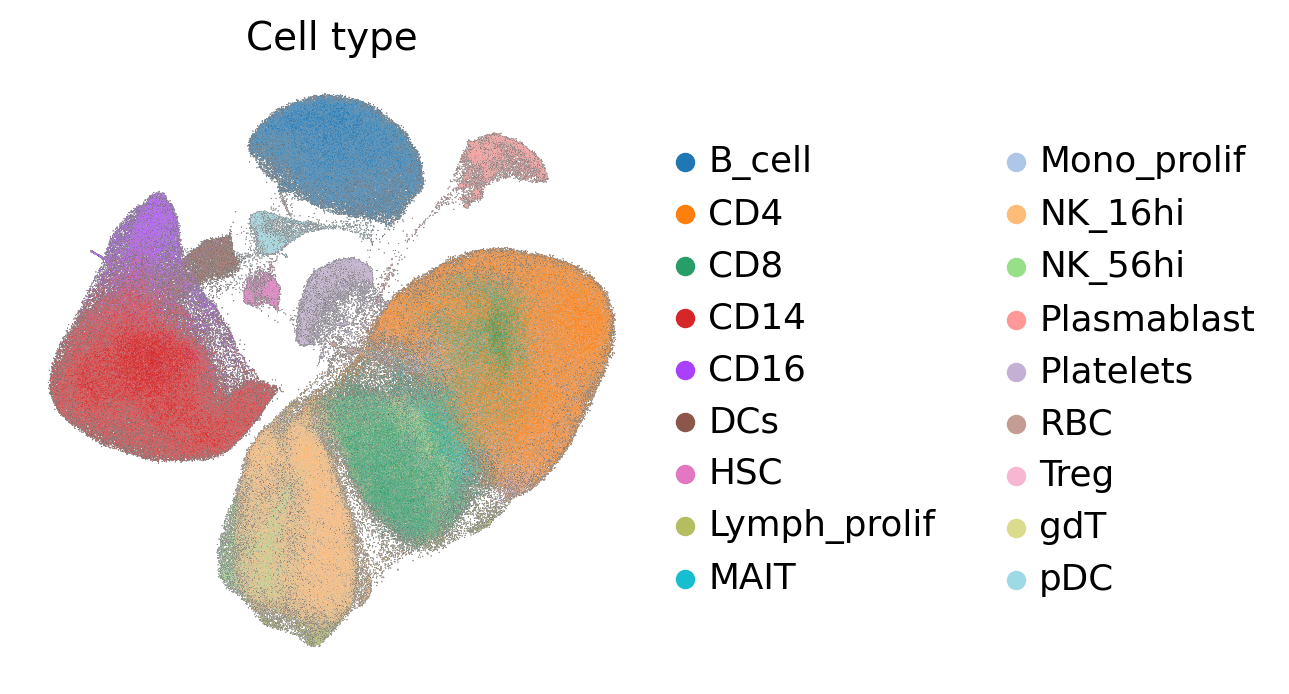

In [616]:
sc.pl.umap(adata, color=['initial_clustering',]
           ,add_outline=True, title="Cell type",
           save="ct_hanifa")

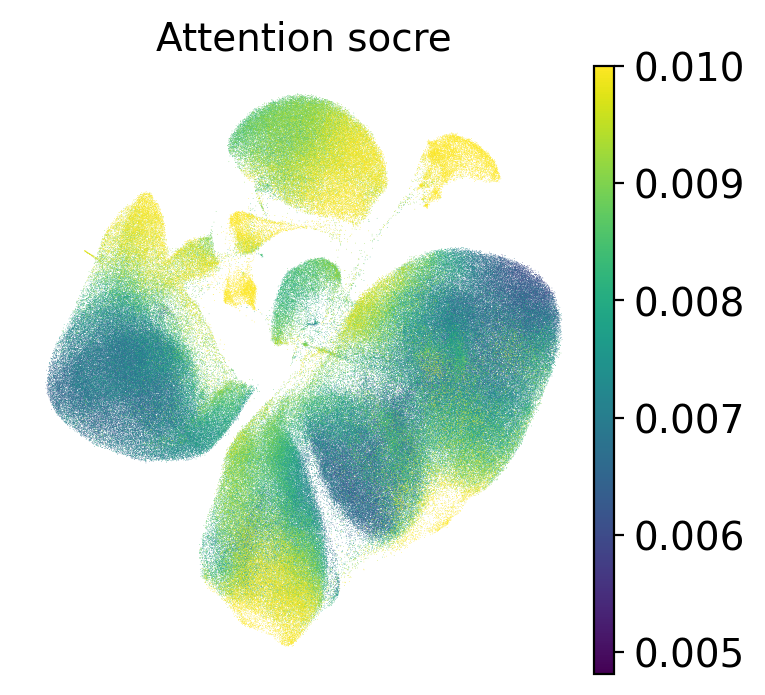

In [615]:
sc.pl.umap(adata, color=['cell_attn'],vmax=0.01, save="cell_att_hanifa", title="Attention socre")

In [77]:
adata.obs.cell_attn = list(adata.obs.cell_attn)

In [202]:
adata.obs["ct_condition"] =  [j + "_" + adata.obs["Status_on_day_collection_summary"][i]
for i,j in enumerate(list(adata.obs["initial_clustering"])) ]

In [230]:
df = adata.obs[["initial_clustering","Status_on_day_collection_summary","cell_attn"]]
# df = df.pivot_table(index='Status_on_day_collection_summary', columns='initial_clustering',values='cell_attn')

In [231]:
df_gp = df.groupby("initial_clustering")

In [232]:
df_mean = df_gp.mean()
df_mean.reset_index(level=0, inplace=True)

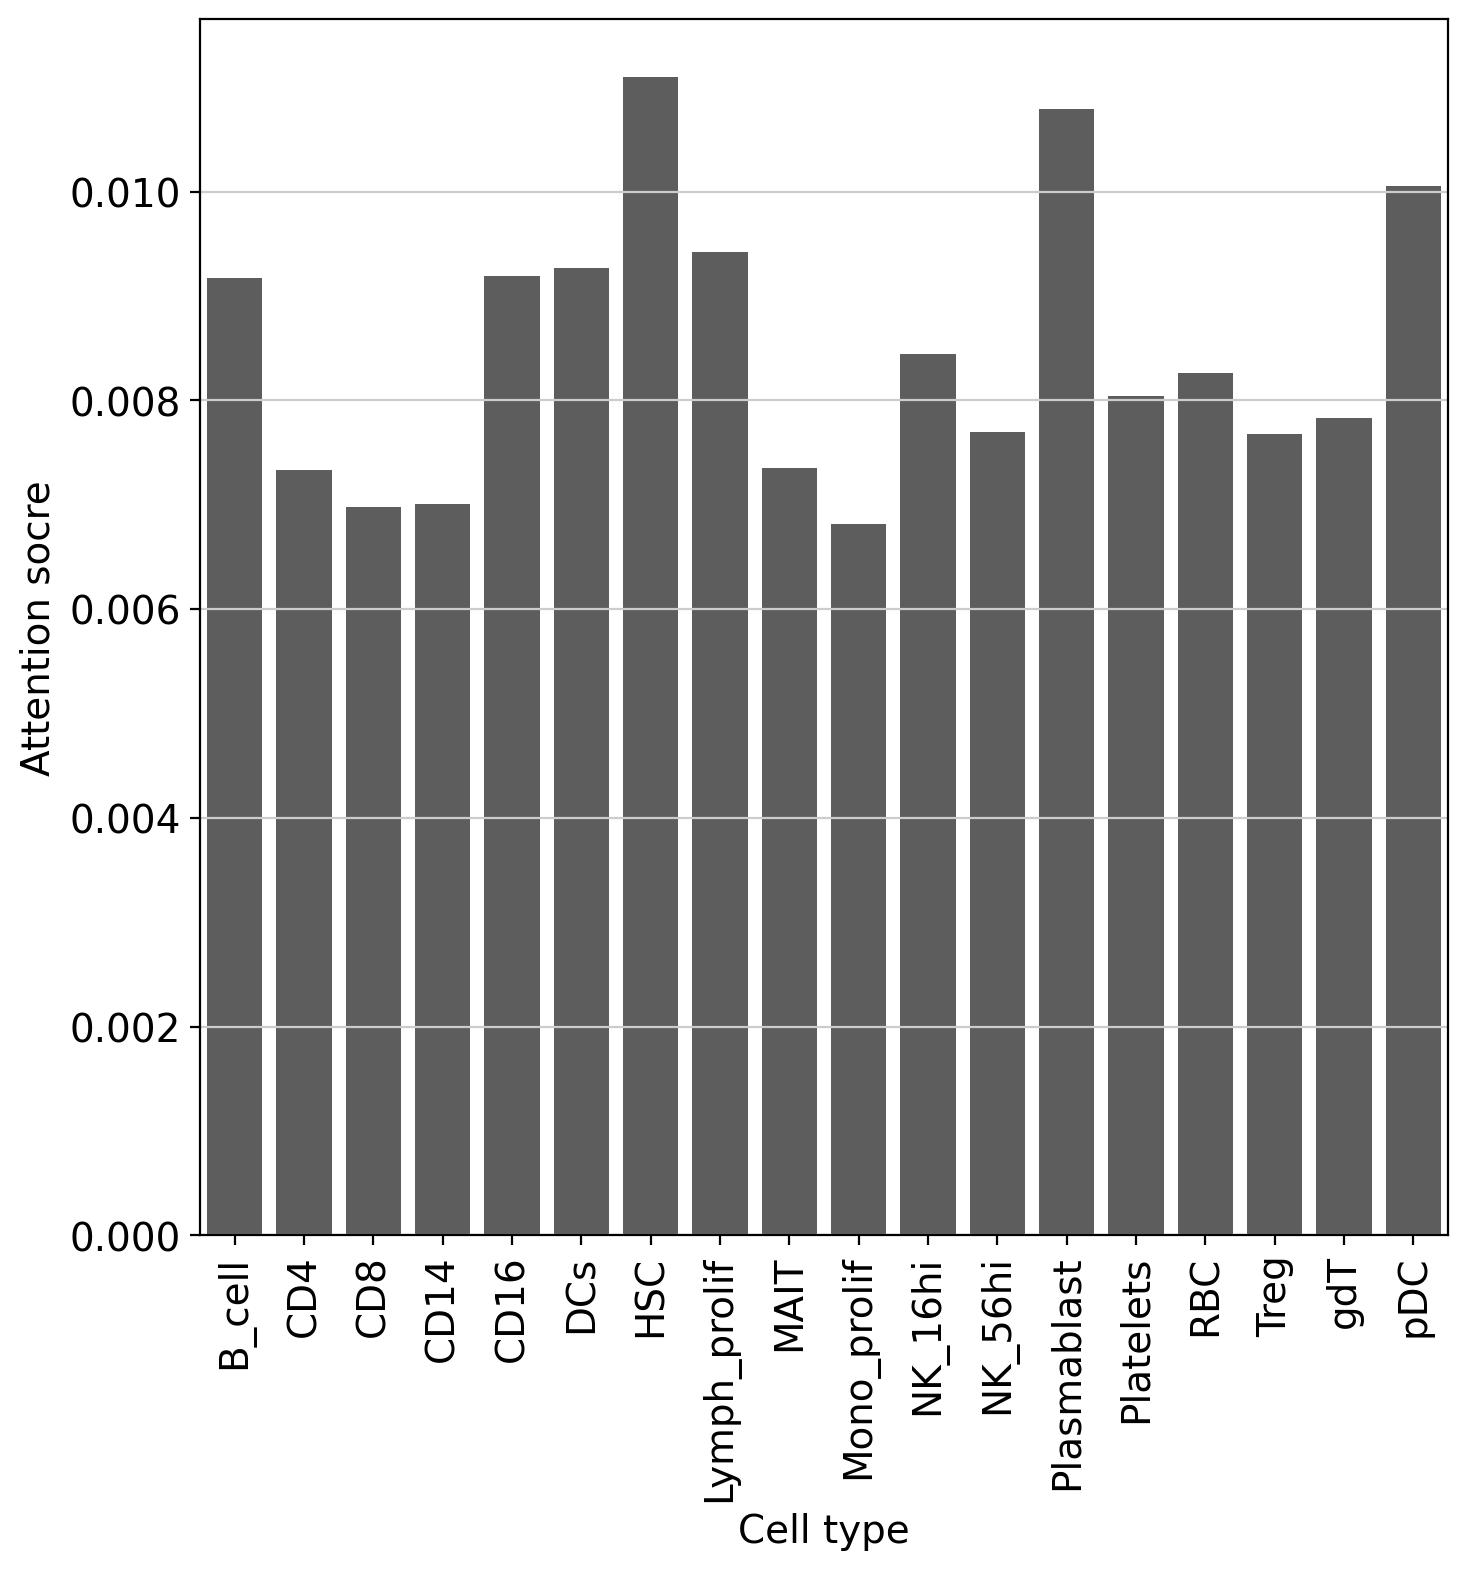

In [619]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
ax=  sns.barplot(x="initial_clustering", y="cell_attn", data=df_mean, color="#5d5d5d")
fig = ax.get_figure()
plt.ylabel("Attention socre")
plt.xlabel("Cell type")
fig.savefig("./figures/att_hanifa_ct.pdf")

In [246]:
IFN_GENES = ['ADAR','ARIH1', 'B2M','CAMK2D', 'CD44','CIITA', 'DDX58', 'EGR1', 'EIF2AK2', 'EIF4A3',
             'EIF4E', 'EIF4E3', 'EIF4G3', 'FCGR1A', 'FCGR1B', 'GBP1', 'GBP2', 'GBP4', 'GBP5', 'HERC5', 
             'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DRB1', 
             'HLA-DRB5', 'HLA-F', 'HLA-G', 'ICAM1', 'IFI27', 'IFI35', 'IFI6', 'IFIT1', 'IFIT2', 'IFIT3', 
             'IFITM1', 'IFITM2', 'IFITM3', 'IFNAR1', 'IFNAR2', 'IFNG', 'IFNGR1', 'IFNGR2', 'IRF1', 'IRF2', 
             'IRF3', 'IRF4', 'IRF5', 'IRF7', 'IRF8', 'IRF9', 'ISG15', 'ISG20', 'JAK1', 'JAK2', 'KPNA1', 
             'KPNA2', 'MAPK3', 'MT2A', 'MX1', 'MX2', 'NCAM1', 'NUP205', 'NUP210', 'NUP214', 'NUP50', 
             'NUP88', 'NUPL2', 'OAS1', 'OAS2', 'OAS3', 'OASL', 'PIAS1', 'PLCG1', 'PML', 'PPM1B', 'PRKCD', 
             'PTAFR', 'PTPN1', 'PTPN6', 'RANBP2', 'SOCS1', 'SOCS3', 'STAT1', 'STAT2', 'TRIM25', 'TYK2',
             'UBA7', 'USP18', 'XAF1']

In [537]:
# df_mean = df.groupby(["initial_clustering","Status_on_day_collection_summary"]).mean().reset_index()
df_mean = df.groupby(["initial_clustering"]).mean().reset_index()

In [546]:
top_att = df_mean[df_mean["cell_attn"] >= df_mean["cell_attn"].median()]

In [554]:
top_att= top_att.sort_values("cell_attn", ascending=False)["initial_clustering"].to_list()

In [555]:
top_att

['HSC',
 'Plasmablast',
 'pDC',
 'Lymph_prolif',
 'DCs',
 'CD16',
 'B_cell',
 'NK_16hi',
 'RBC']

### Gene score analysis om the full data, TODOL: has to be replaced with full data with all genes to caluclate the scores

In [502]:
sc.pp.normalize_per_cell(rna)
sc.pp.log1p(rna)

In [521]:
sc.tl.score_genes(rna,IFN_GENES, ctrl_size=200)

In [522]:
df_full = rna.obs[["initial_clustering","Status_on_day_collection_summary","score"]]


In [523]:
df_mean_full = df_full.groupby(["initial_clustering","Status_on_day_collection_summary"]).mean().reset_index()

In [560]:
df_mean_full_ss = df_mean_full[df_mean_full.initial_clustering.isin(np.unique(top_att[:5]))]

In [563]:
df_mean_full_ss.initial_clustering = df_mean_full_ss.initial_clustering.cat.remove_unused_categories()

/home/mo/miniconda3/envs/multigrate/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Gene score for top attented cells 

In [570]:
order = ["Healthy", "Asymptomatic", "Mild", "Moderate", "Severe", "Critical"]

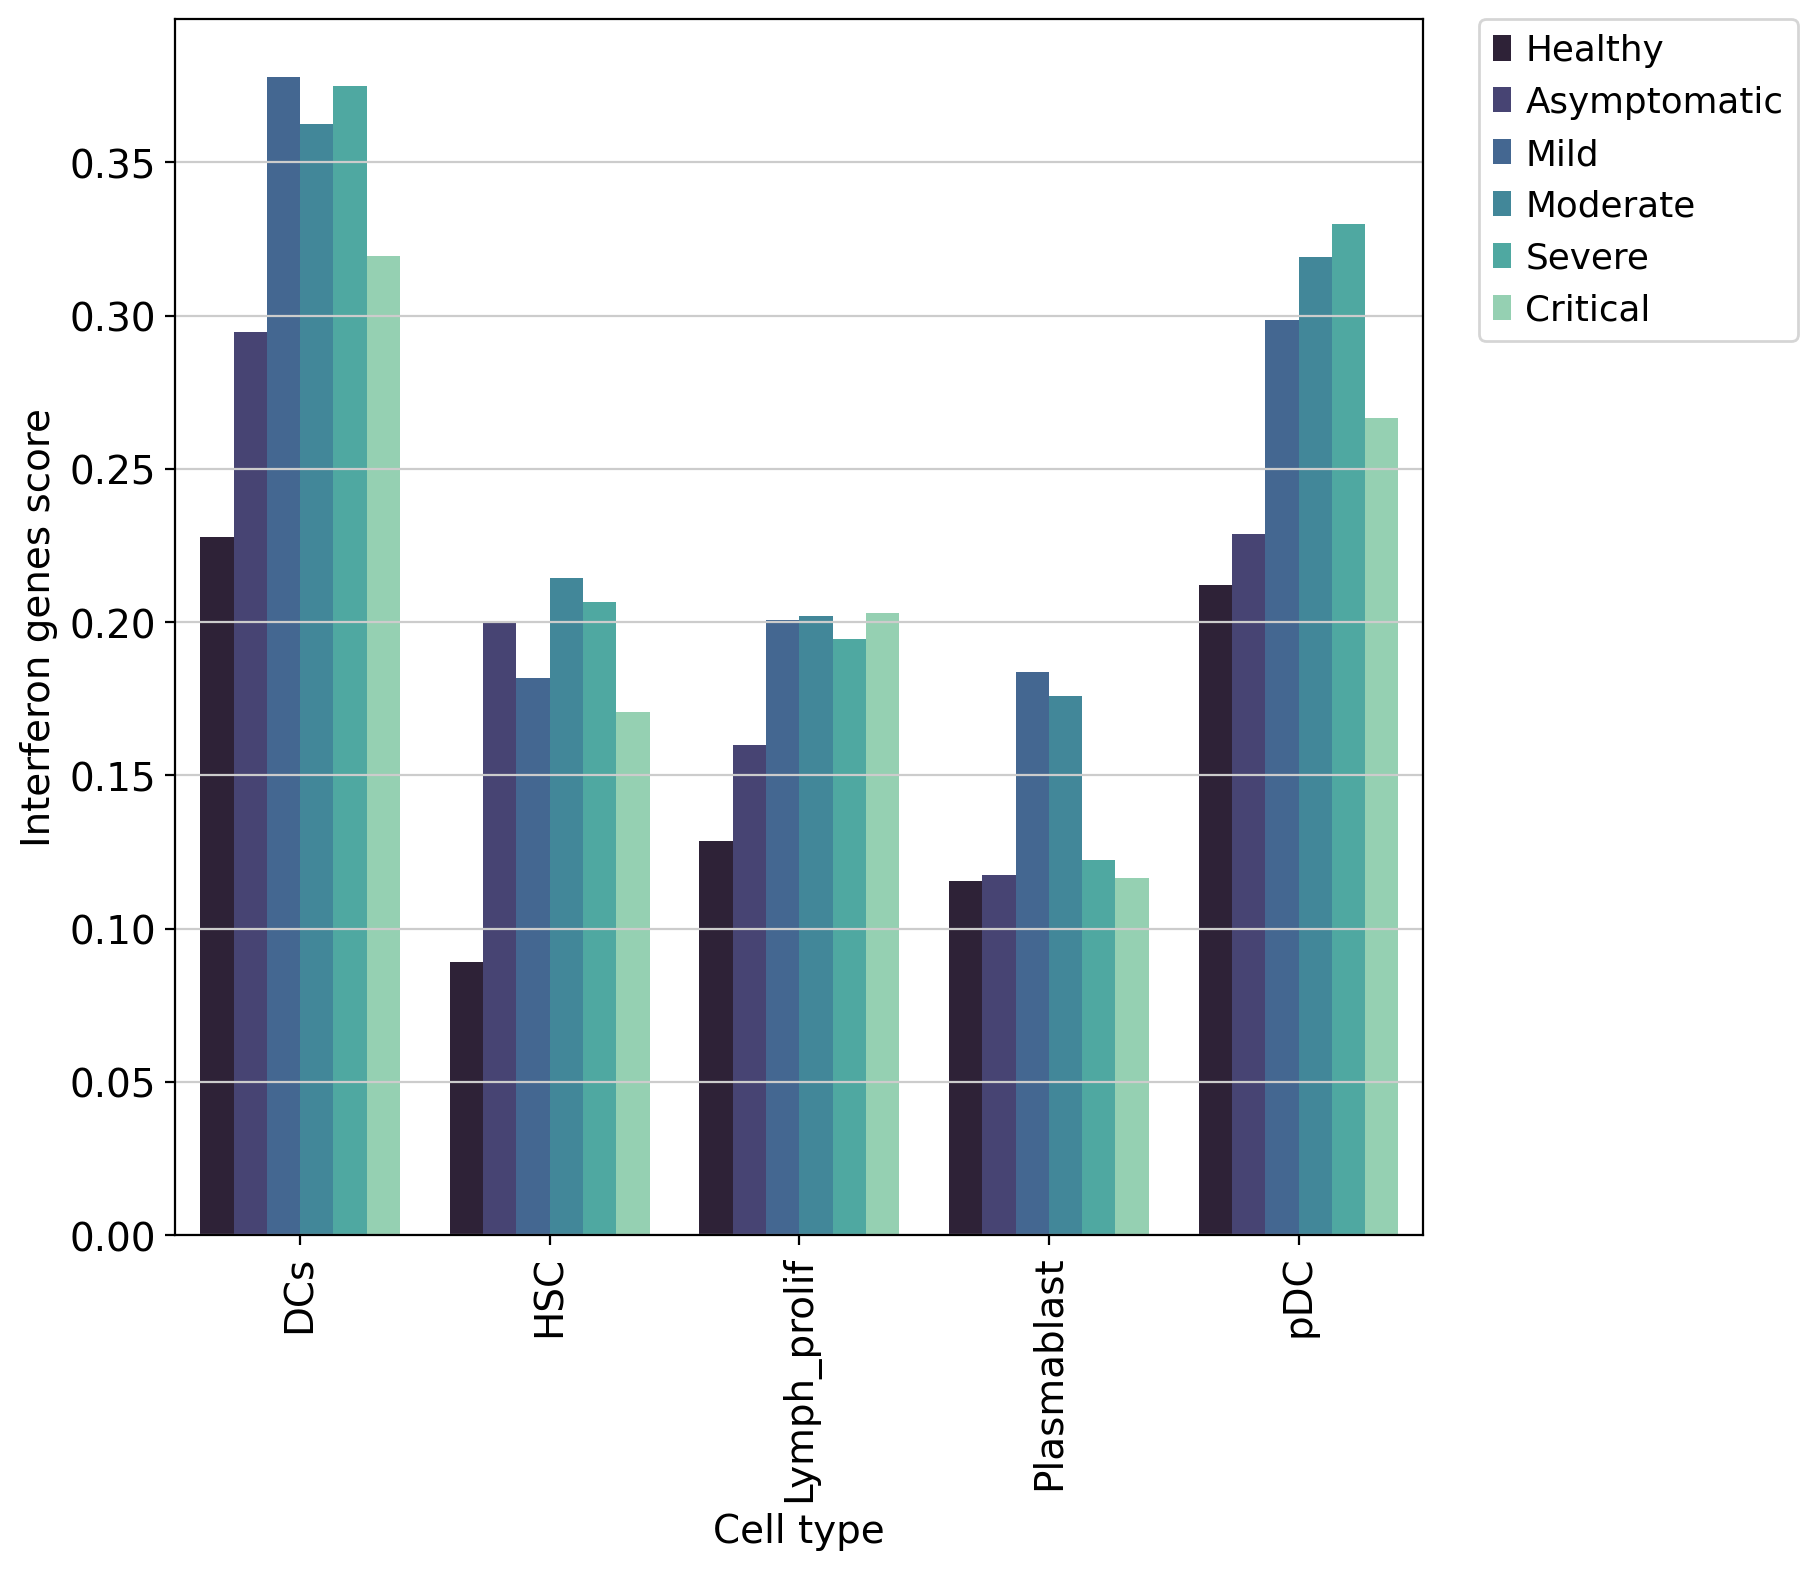

In [620]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="score",
            data= df_mean_full_ss, hue="Status_on_day_collection_summary",
            hue_order=order, palette="mako", )
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct.pdf")

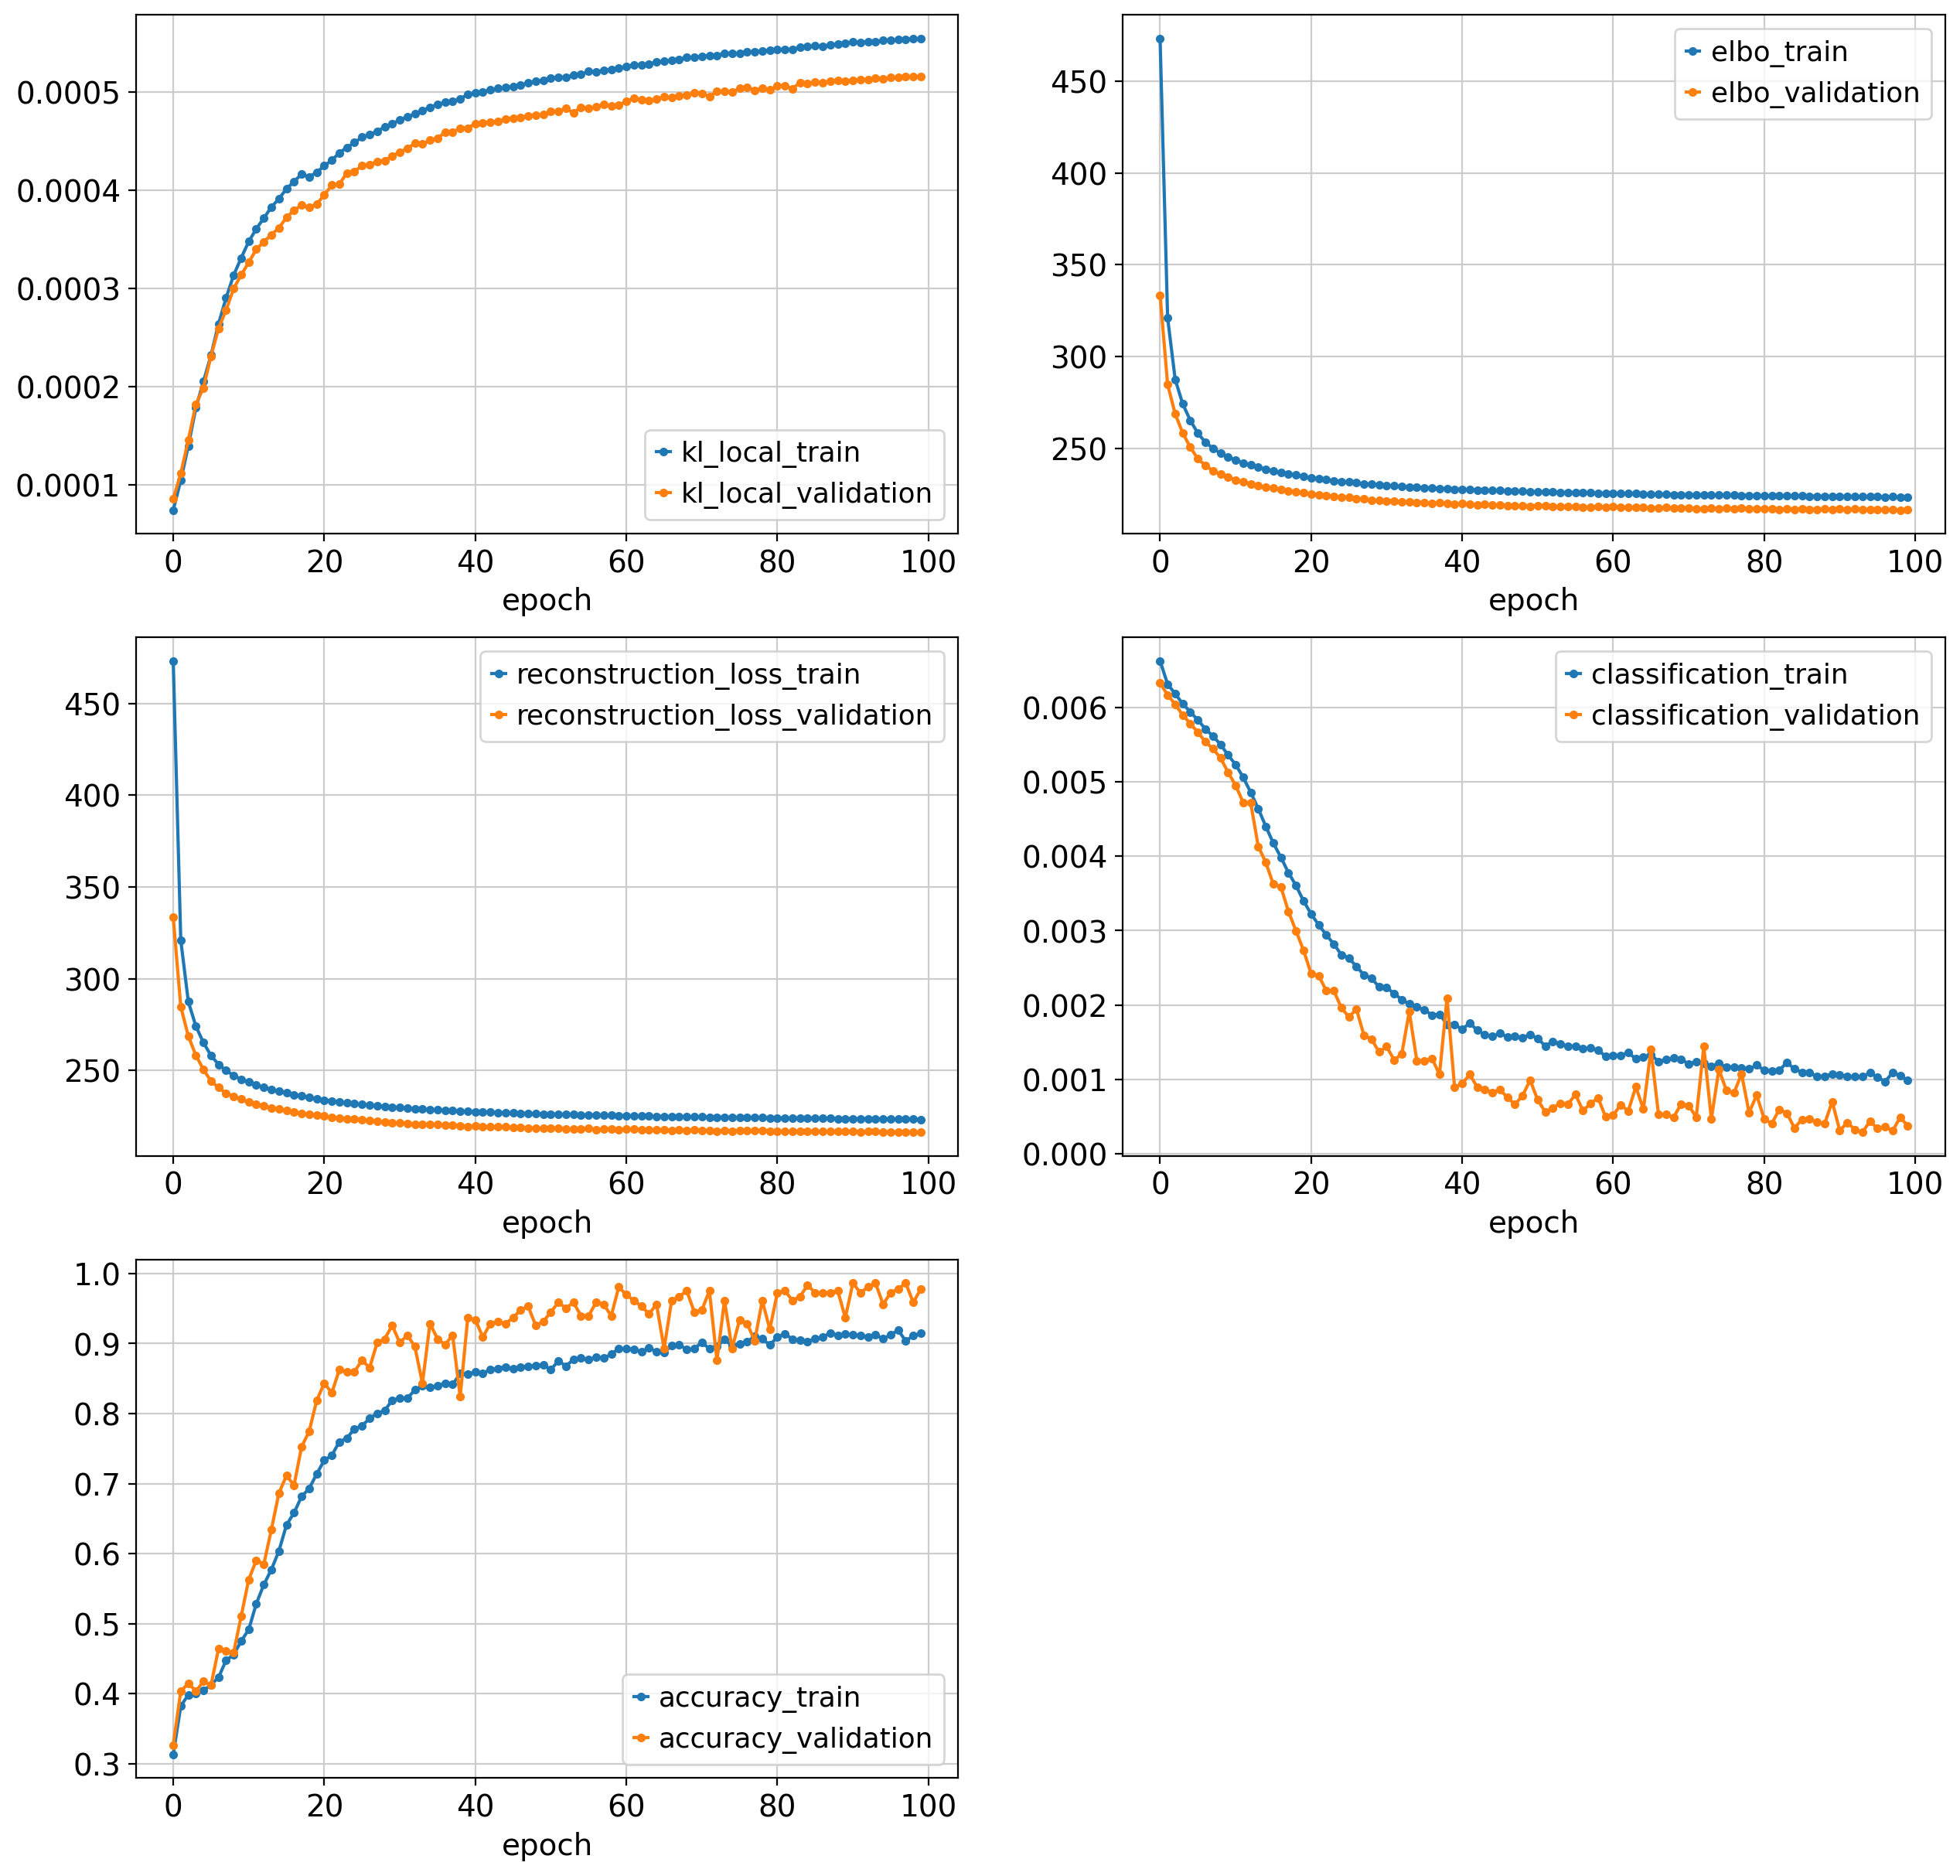

In [565]:
df = pd.DataFrame(mil.history['train_loss_step'])
for key in mil.history.keys():
    if key != 'train_loss_step':
        df = df.join(mil.history[key])

df['epoch'] = df.index

plt.figure(figsize=(15, 15))
loss_names = ['kl_local', 'elbo', 'reconstruction_loss', 'classification', 'accuracy']
nrows = 3

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+1)
    plt.plot(df['epoch'], df[name+'_train'], '.-', label=name+'_train')
    plt.plot(df['epoch'], df[name+'_validation'], '.-', label=name+'_validation')
    plt.xlabel('epoch')
    plt.legend()

In [58]:
# first is always molecular information, 
# then categorical covariate as they were specified with setup_anndata, 
# then continuous
cov_attn.shape

(524368, 3)

In [59]:
# i.e. in this case
adata.obs['molecular_attn'] = cov_attn[:, 0]
adata.obs['sex_attn'] = cov_attn[:, 1]
adata.obs['age_attn'] = cov_attn[:, 2]

In [61]:
adata.obs['molecular_attn']

covid_index
S12_TCGAGGCGTCCGACGT-1          0.492270
S12_TCGTAGATCCTTTCGG-1          0.550237
S11_ATTGGTGCACGGACAA-1          0.492270
S12_CCCAGTTTCACTTCAT-1          0.550237
S12_GAACATCAGCACAGGT-1          0.492270
                                  ...   
GGATTACCAATTGCTG-newcastle74    0.407575
GGATTACCACGGTAGA-newcastle74    0.407575
GGATTACCAGAAGCAC-newcastle74    0.407575
GGATGTTTCTCTAGGA-newcastle74    0.407575
GATCTAGGTGTGACGA-newcastle74    0.407575
Name: molecular_attn, Length: 524368, dtype: float32